In this notebook, I am going to show an implementation for the churn data classification problem. The goal is to create a model that predicts whether a customer is going to leave the supplier.

We know the following information about the dataset (as quoted from https://www.kaggle.com/blastchar/telco-customer-churn):

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

For starting, import the libraries used in the task.

In [2]:
import numpy as np
import tensorflow as tf
import traceback
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import resample
from enum import Enum

# silence warnings for jupyter notebook readability
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# set a random state
rnd_state = 37

Read the data from the file.

In [3]:
def get_data():
    churn_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

    return churn_data

churn_data = get_data()
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Filter out rows with missing values; they will be deleted to make sure that the read data can be preprocessed without any errors.

In [4]:
# find and drop rows with missing values
churn_data = churn_data.replace(" ", np.NaN)
old_size = len(churn_data.index)
churn_data = churn_data.dropna()
print('Number of dropped rows with missing values: {}'.format(old_size-len(churn_data.index)))

Number of dropped rows with missing values: 11


Look at the number of unique values by each column:

In [5]:
pd.set_option('display.max_columns', None)
churn_data.agg(['size', 'nunique'])

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
size,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032
nunique,7032,2,2,2,2,72,2,3,3,3,3,3,3,3,3,3,2,4,1584,6530,2


Most features have 2-3 values as they are categorized. Tenure, monthly charges and total charges have a lot more, since they are numeric features. CustomerID is unique for every row as it is an ID, and can be deleted from the table since it has nothing to do whether a churn happened or not.

In [6]:
# we can delete customerID as it is not relevant for the prediction
churn_data = churn_data.drop(columns=['customerID'])

The next step is to separate the featues to categorical and numeric ones as they will be handled differently in the classification process. The numeric features can be also normalized be fall between 0 and 1 so they will be on the same scale.

In [7]:
# separate numeric and categorical features
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
churn_data[numeric_features] = churn_data[numeric_features].apply(pd.to_numeric)

def normalize_columns(data, features):
    min_max_scaler = MinMaxScaler()
    num_values = data[features].values
    num_values_scaled = min_max_scaler.fit_transform(num_values)
    data[features] = pd.DataFrame(num_values_scaled, columns=features, index=data.index)

    return data

# normalize numerical features to be between [0, 1]
churn_data = normalize_columns(churn_data, numeric_features)

# collect categorical features
categorical_features = [col for col in churn_data if col not in numeric_features]

We can plot the ratio of churn by each categorical feature to get more insight of the data:

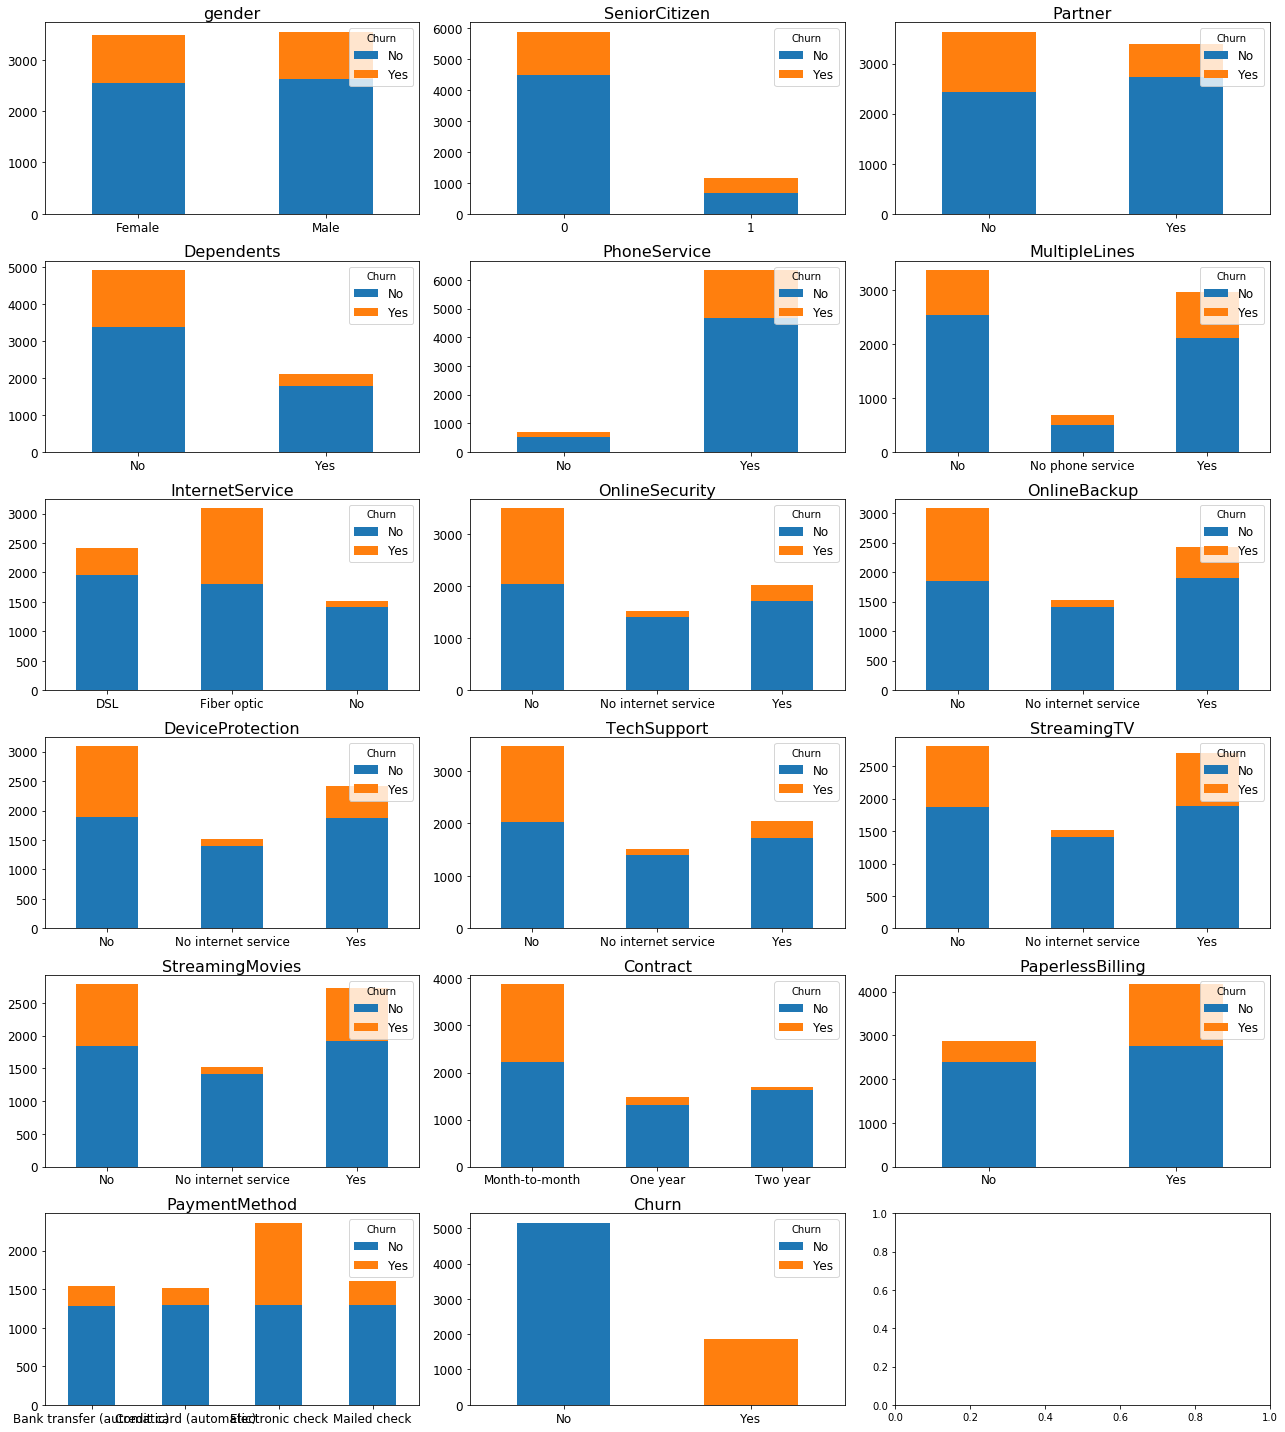

In [8]:
# plot churn ratio on by each categorical feature
fig, ax = plt.subplots(6, 3, figsize=(18, 20))
axes = ax.flatten()
for i, c in enumerate(categorical_features):
    churn_data.groupby([c, 'Churn']).size().unstack().plot(ax=axes[i], kind='bar', stacked=True)
    axes[i].tick_params(labelrotation=0, labelsize=12)
    axes[i].xaxis.set_label_position('top')
    axes[i].set_xlabel(c, fontsize=16)
    axes[i].legend(prop=dict(size=12), loc="upper right", title='Churn')
fig.tight_layout()
plt.show()

The diagrams imply that by each feature there is a category (e.g. Internet service - Fiber optic) where people were a lot more likely to leave compared to the "best performing" category in the same feature (e.g. Internet service - No). By just looking at them, only the gender column seems quite unimportant in terms of churn, as it shows a very balanced ratio.

After making the plot, the categorical features are converted by sklearn's LabelEncoder.

In [9]:
def convert_columns_to_categorical(data, features):
    LE = LabelEncoder()
    for col in data:
        if col in features:
            data[col] = LE.fit_transform(data[col])
    return data

# convert string values to categories
churn_data = convert_columns_to_categorical(churn_data, categorical_features)
# since the churn column will be the label column, remove it from the features
categorical_features.remove('Churn')

Now we can check the correlation map of the dataset:

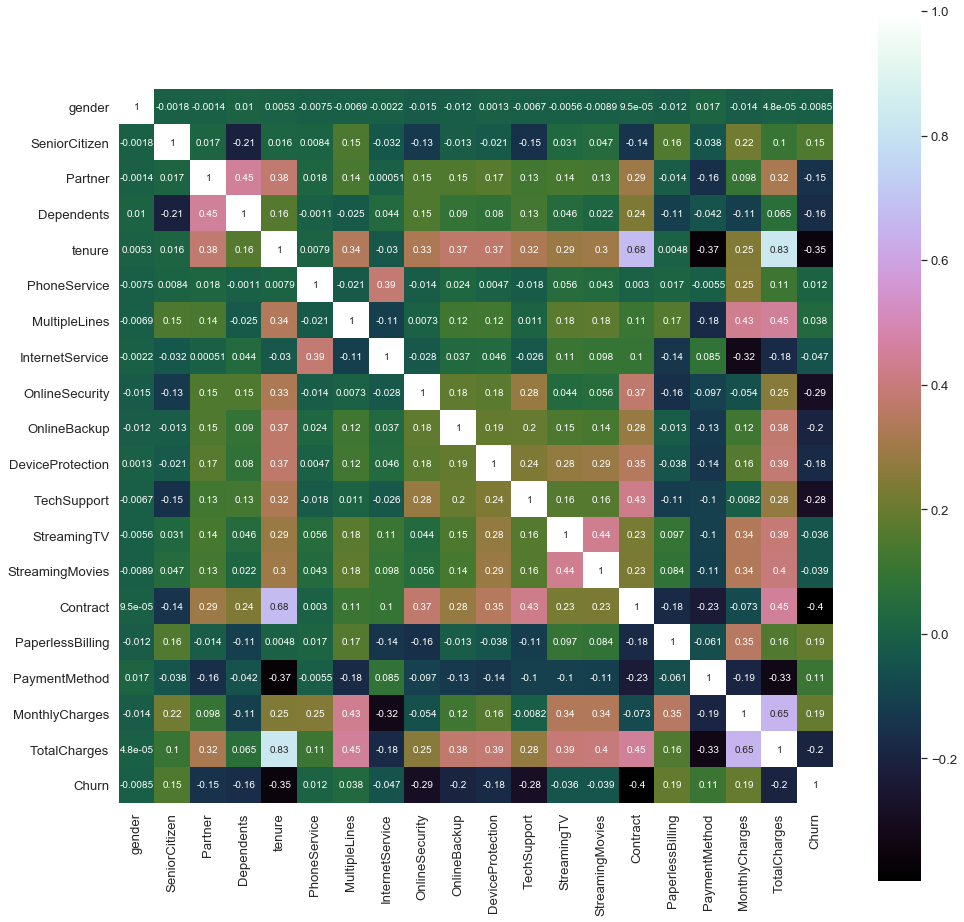

In [10]:
correlation = churn_data.corr()
plt.figure(figsize=(16, 16))
sns.set(font_scale=1.2)
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix', annot_kws={"size": 10})
plt.show()

The following features seem to be correlated:
* tenure, monthly charges, total charges: it is not surprising as _tenure\*monthly charges=total charges_ roughly. It would make sense to delete either tenure and monthly charges or only total charges from the dataset to avoid redundancy, but later in the code there will be feature importance score computation to see if leaving any column out makes a better performing model or not.
* partner, dependents: having a partner and having a bigger chance of dependents (for example children) seems reasonable
* multiple lines, total charges, monthly charges: also reasonable that if you keep multiple telephone lines, it costs you more
* contract, total charges: this might be due different prices on different plans

Now I wrap up the classification part into a function so multiple variants can be run on and be compared on the dataset. The funciton has three flags: drop_out_features, upsample and estimator_type.
* drop_out_features: if True, an additional function is run to determine which columns are not important in the classification. The function first creates a benchmark model and saves its accuracy score, then it replaces each column by its permuted version and trains each model this way, then compares the new model's score with the benchmark score. If the accuracy doesn't fall greatly, it means it was an unimportant feature in the original classification.
* upsample: since the ratio between no churns and churns is about 72-28%, a model that always predicts no churn would still have the accuracy of ~72%. To make the dataset more balanced (and therefore make the model predict churn more accurately), the rows with churn outcome can be upsampled.
* estimator_type: I included implementation for LinearClassifier, DNNClassifier and BoostedTreesClassifier for comparison motives

The function will consider these options and train a given classifier as well as return a confusion matrix and results on the evaluation data.

In [11]:
class EstimatorType(Enum):
    DNN = 1
    Linear = 2
    BoostedTrees = 3

    
def drop_unimportant_features(data, features):
    data = data.drop(features, axis=1)
    return data


def check_important_features(X_train, X_test, y_train, y_test):
    try:
        # make y shape compatible with sklearn functions
        y_train = y_train.values.ravel()
        y_test = y_test.values.ravel()

        # create and train a baseline model
        model = RandomForestClassifier(n_estimators=20, random_state=rnd_state)
        model.fit(X_train, y_train)

        # permutation feature importance
        perm = PermutationImportance(model, cv=None, random_state=rnd_state, 
                                     refit=False).fit(X_test, y_test)
        imp_scores = pd.concat([pd.DataFrame(X_train.columns), 
                                pd.DataFrame(perm.feature_importances_)], axis=1)
        imp_scores.columns = ['Feature', 'Score']
        print('Permutation importance scores:', imp_scores.nlargest(20, 'Score'), sep='\n', end='\n\n')
        # features are dropped if they do not influence the accuracy much when their values are shuffled
        features_to_drop = imp_scores.query('Score < 0.005')['Feature']
        print('Features to drop out: {}'.format(features_to_drop.values.tolist()))

        return features_to_drop.values.tolist()

    except Exception as e:
        print(e)
        print(traceback.format_exc())


def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    # input function for the tensorflow estimator
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function


def run_classification(churn_data, numeric_features, categorical_features, 
                       drop_out_features, upsample, estimator_type):
    try:
        # use upsampling (conditional)
        if upsample:
            churn_data_negatives = churn_data[churn_data['Churn'] == 0]
            churn_data_positives = churn_data[churn_data['Churn'] == 1]

            # upsample positives to have 4000 samples in the dataset (will make up now 46% of the whole)
            churn_data_positives = resample(churn_data_positives, replace=True, 
                                            n_samples=4000, random_state=rnd_state)
            churn_data = pd.concat([churn_data_negatives, churn_data_positives])

        # separate features and labels column
        y = churn_data[['Churn']]
        X = churn_data.drop(columns=['Churn'])

        # separate training and validation sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=rnd_state)

        # compute which columns are making the validation scores worse in a simple model
        # and drop them out (conditional)
        if drop_out_features:
            features_to_drop = check_important_features(X_train, X_test, y_train, y_test)
            X_train = drop_unimportant_features(X_train, features_to_drop)
            X_test = drop_unimportant_features(X_test, features_to_drop)
            numeric_features = [n for n in numeric_features if n not in features_to_drop]
            categorical_features = [c for c in categorical_features if c not in features_to_drop]
            print('Features to stay: ' + str(categorical_features + numeric_features))

        # create estimator
        feature_columns = []
        # convert all the columns to tensorflow's feature column type
        # first the categorical ones,
        for feature_name in categorical_features:
            vocabulary = X_train[feature_name].unique()
            if estimator_type == EstimatorType.Linear:
                feature_columns.append(
                    tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))
            elif estimator_type in [EstimatorType.DNN, EstimatorType.BoostedTrees]:
                categorical_feature = tf.feature_column.categorical_column_with_vocabulary_list(
                    feature_name, vocabulary)
                feature_columns.append(tf.feature_column.indicator_column(categorical_feature))
            else:
                raise ValueError('Unknown estimator type')
        # secondly the numeric ones
        for feature_name in numeric_features:
            feature_columns.append(tf.feature_column.numeric_column(feature_name))

        # create the input for the estimator
        train_input_fn = make_input_fn(X_train, y_train)
        eval_input_fn = make_input_fn(X_test, y_test, num_epochs=1, shuffle=False)

        # init the given estimator type
        if estimator_type == EstimatorType.Linear:
            estimator = tf.estimator.LinearClassifier(feature_columns=feature_columns)
        elif estimator_type == EstimatorType.DNN:
            estimator = tf.estimator.DNNClassifier(feature_columns=feature_columns, 
                                                   hidden_units=[1024, 512])
        elif estimator_type == EstimatorType.BoostedTrees:
            estimator = tf.estimator.BoostedTreesClassifier(feature_columns=feature_columns, 
                                                            n_batches_per_layer=128)
        else:
            raise ValueError('Unknown estimator type')

        # train and evaluate
        estimator.train(train_input_fn, max_steps=2500)
        result = estimator.evaluate(eval_input_fn)

        # get true test labels and predicted labels into lists
        pred_dicts = list(estimator.predict(eval_input_fn))
        y_pred = [round(pred['probabilities'][1]) for pred in pred_dicts]
        # create confusion matrix on the test data
        conf_matrix = confusion_matrix(y_test.values.tolist(), y_pred)

        print('Results for the setting - estimator type={}, upsampling={}, drop out features={}:'
              .format(estimator_type, upsample, drop_out_features))
        print(result, end='\n\n')

        return result, conf_matrix

    except Exception as e:
        print(e)
        print(traceback.format_exc())

To check how well models are performing with upsampling and drop out columns, I run three models to compare:
* linear estimator
* linear estimator on upsampled data
* linear estimator on upsampled data with dropping small importance columns

Results for the setting - estimator type=EstimatorType.Linear, upsampling=False, drop out features=False:
{'accuracy': 0.80379146, 'accuracy_baseline': 0.72701424, 'auc': 0.856953, 'auc_precision_recall': 0.69695055, 'average_loss': 0.4070866, 'label/mean': 0.2729858, 'loss': 0.40710232, 'precision': 0.6680498, 'prediction/mean': 0.26817155, 'recall': 0.5590278, 'global_step': 1870}

Results for the setting - estimator type=EstimatorType.Linear, upsampling=True, drop out features=False:
{'accuracy': 0.75563633, 'accuracy_baseline': 0.576, 'auc': 0.82589513, 'auc_precision_recall': 0.7622899, 'average_loss': 0.5053572, 'label/mean': 0.424, 'loss': 0.5054599, 'precision': 0.7155323, 'prediction/mean': 0.4177841, 'recall': 0.703259, 'global_step': 2440}

Permutation importance scores:
             Feature     Score
4             tenure  0.107200
14          Contract  0.100800
18      TotalCharges  0.097164
17    MonthlyCharges  0.079418
8     OnlineSecurity  0.050327
11       TechSupport 

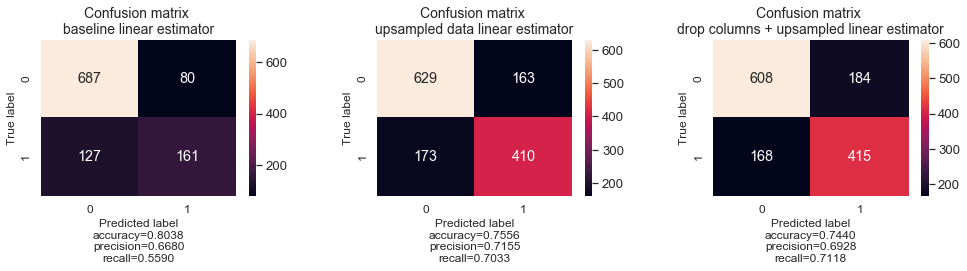

In [12]:
baseline_result, baseline_conf_matrix = run_classification(churn_data, numeric_features, 
                                                           categorical_features,
                                                           drop_out_features=False, upsample=False,
                                                           estimator_type=EstimatorType.Linear)

upsampled_result, upsampled_conf_matrix = run_classification(churn_data, numeric_features, 
                                                             categorical_features,
                                                             drop_out_features=False, upsample=True,
                                                             estimator_type=EstimatorType.Linear)

dropcolumn_result, dropcolumn_conf_matrix = run_classification(churn_data, numeric_features, 
                                                               categorical_features,
                                                               drop_out_features=True, upsample=True,
                                                               estimator_type=EstimatorType.Linear)

results = [baseline_result, upsampled_result, dropcolumn_result]
conf_matrices = [baseline_conf_matrix, upsampled_conf_matrix, dropcolumn_conf_matrix]
titles = ['baseline linear estimator', 'upsampled data linear estimator',
          'drop columns + upsampled linear estimator']

# plot linear model confusion matrices with and without upsampling
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
axes = ax.flatten()
for i, cm in enumerate(conf_matrices):
    sns.heatmap(pd.DataFrame(cm), ax=axes[i], annot=True, fmt='g')
    axes[i].set_ylabel('True label', fontsize=12)
    axes[i].set_xlabel('Predicted label\naccuracy={:0.4f}\nprecision={:0.4f}\nrecall={:0.4f}'
                       .format(results[i]['accuracy'], results[i]['precision'], 
                               results[i]['recall']), fontsize=12)
    axes[i].set_title('Confusion matrix \n{}'.format(titles[i]), fontdict={'fontsize': 14})
    axes[i].tick_params(labelsize=12)
plt.gcf().subplots_adjust(left=0.3, right=0.9, bottom=0.3, top=0.9)
fig.tight_layout()
plt.show()

Out of the three models, the baseline model seems the best in accuracy - but it is because of the imbalanced dataset. The recall metrics tells the almost half of the happened churns were predicted as non-happening.
The upsampled model has a lot better ratio with its ~0.70 recall. The accuracy is only ~76% but maybe it can be improved with a different estimator selection.
Dropping a few seemingly unimportant columns result in a very similar results on the test set in the end, so I decide not to use that flag for the next variants.

To compare other pre-made estimators, a similar script can be run:

Results for the setting - estimator type=EstimatorType.Linear, upsampling=True, drop out features=False:
{'accuracy': 0.7541818, 'accuracy_baseline': 0.576, 'auc': 0.826077, 'auc_precision_recall': 0.7635402, 'average_loss': 0.50567424, 'label/mean': 0.424, 'loss': 0.5057799, 'precision': 0.7101201, 'prediction/mean': 0.4264612, 'recall': 0.7101201, 'global_step': 2440}

Results for the setting - estimator type=EstimatorType.DNN, upsampling=True, drop out features=False:
{'accuracy': 0.7490909, 'accuracy_baseline': 0.576, 'auc': 0.819177, 'auc_precision_recall': 0.7453085, 'average_loss': 0.5140705, 'label/mean': 0.424, 'loss': 0.5141777, 'precision': 0.70307165, 'prediction/mean': 0.4328955, 'recall': 0.70668954, 'global_step': 2440}

Results for the setting - estimator type=EstimatorType.BoostedTrees, upsampling=True, drop out features=False:
{'accuracy': 0.75927275, 'accuracy_baseline': 0.576, 'auc': 0.84090364, 'auc_precision_recall': 0.77809036, 'average_loss': 0.50018036, 'label/

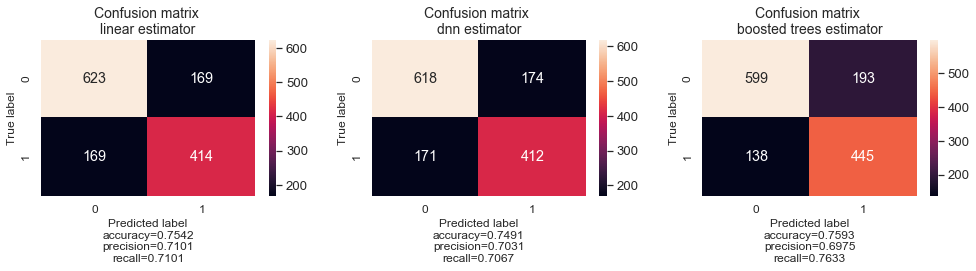

In [13]:
linear_result, linear_conf_matrix = run_classification(churn_data, numeric_features, categorical_features,
                                                           drop_out_features=False, upsample=True,
                                                           estimator_type=EstimatorType.Linear)

dnn_result, dnn_conf_matrix = run_classification(churn_data, numeric_features, categorical_features,
                                                 drop_out_features=False, upsample=True,
                                                 estimator_type=EstimatorType.DNN)

boosted_trees_result, boosted_trees_conf_matrix = run_classification(churn_data, numeric_features, 
                                                                     categorical_features,
                                                                     drop_out_features=False, 
                                                                     upsample=True,
                                                                     estimator_type=EstimatorType.BoostedTrees)

results = [linear_result, dnn_result, boosted_trees_result]
conf_matrices = [linear_conf_matrix, dnn_conf_matrix, boosted_trees_conf_matrix]
titles = ['linear estimator', 'dnn estimator',
          'boosted trees estimator']

# plot linear model confusion matrices with and without upsampling
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
axes = ax.flatten()
for i, cm in enumerate(conf_matrices):
    sns.heatmap(pd.DataFrame(cm), ax=axes[i], annot=True, fmt='g')
    axes[i].set_ylabel('True label', fontsize=12)
    axes[i].set_xlabel('Predicted label\naccuracy={:0.4f}\nprecision={:0.4f}\nrecall={:0.4f}'
                       .format(results[i]['accuracy'], results[i]['precision'], results[i]['recall']), fontsize=12)
    axes[i].set_title('Confusion matrix \n{}'.format(titles[i]), fontdict={'fontsize': 14})
    axes[i].tick_params(labelsize=12)
plt.gcf().subplots_adjust(left=0.3, right=0.9, bottom=0.3, top=0.9)
fig.tight_layout()
plt.show()

The models are performing very similarly again but seemingly BoostedTrees is the best.

As BoostedTrees are decision tree based, I run a comparison test with it and sklearn's random forest classifier. 
For this, I need to modify the run classification function to include this very different library/model. Here in this notebook, I re-create a very similar function with only having random forest in it instead.

In [14]:
def run_rf_classification(churn_data, numeric_features, categorical_features, 
                          drop_out_features, upsample):
    try:
        # use upsampling (conditional)
        if upsample:
            churn_data_negatives = churn_data[churn_data['Churn'] == 0]
            churn_data_positives = churn_data[churn_data['Churn'] == 1]

            # upsample positives to have 4000 samples in the dataset (will make up now 46% of the whole)
            churn_data_positives = resample(churn_data_positives, replace=True, 
                                            n_samples=4000, random_state=rnd_state)
            churn_data = pd.concat([churn_data_negatives, churn_data_positives])

        # separate features and labels column
        y = churn_data[['Churn']]
        X = churn_data.drop(columns=['Churn'])

        # separate training and validation sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=rnd_state)

        # compute which columns are making the validation scores worse in a simple model
        # and drop them out (conditional)
        if drop_out_features:
            features_to_drop = check_important_features(X_train, X_test, y_train, y_test)
            X_train = drop_unimportant_features(X_train, features_to_drop)
            X_test = drop_unimportant_features(X_test, features_to_drop)
            numeric_features = [n for n in numeric_features if n not in features_to_drop]
            categorical_features = [c for c in categorical_features if c not in features_to_drop]
            print('Features to stay: ' + str(categorical_features + numeric_features))

        # train and evaluate
        rf_model = RandomForestClassifier(n_estimators=20, random_state=rnd_state)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)

        result = dict()
        result['accuracy'] = rf_model.score(X_test, y_test)
        result['precision'] = precision_score(y_test, y_pred, average="macro")
        result['recall'] = recall_score(y_test, y_pred, average="macro")

        conf_matrix = confusion_matrix(y_test.values.tolist(), y_pred)

        print('Results for the setting - random forest:')
        print(result)

        return result, conf_matrix

    except Exception as e:
        print(e)
        print(traceback.format_exc())

For the last comparison, let's see the confusion matrices on these two models:

Results for the setting - estimator type=EstimatorType.BoostedTrees, upsampling=True, drop out features=False:
{'accuracy': 0.75636363, 'accuracy_baseline': 0.576, 'auc': 0.8411592, 'auc_precision_recall': 0.78339976, 'average_loss': 0.49953958, 'label/mean': 0.424, 'loss': 0.49958348, 'precision': 0.705298, 'prediction/mean': 0.44433573, 'recall': 0.73070323, 'global_step': 2312}

Results for the setting - random forest:
{'accuracy': 0.872, 'precision': 0.8689008731381613, 'recall': 0.8764412997903563}


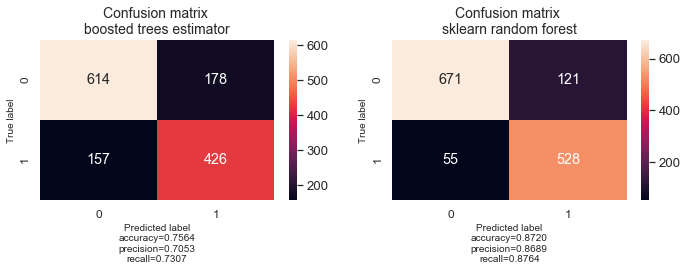

In [15]:
boosted_trees_result, boosted_trees_conf_matrix = run_classification(churn_data, numeric_features,
                                                                     categorical_features,
                                                                     drop_out_features=False, 
                                                                     upsample=True,
                                                                     estimator_type=EstimatorType.BoostedTrees)

random_forest_result, random_forest_conf_matrix = run_rf_classification(churn_data, numeric_features,
                                                                        categorical_features,
                                                                        drop_out_features=False, 
                                                                        upsample=True)

results = [boosted_trees_result, random_forest_result]
conf_matrices = [boosted_trees_conf_matrix, random_forest_conf_matrix]
titles = ['boosted trees estimator', 'sklearn random forest']

# plot linear model confusion matrices with and without upsampling
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
axes = ax.flatten()
for i, cm in enumerate(conf_matrices):
    sns.heatmap(pd.DataFrame(cm), ax=axes[i], annot=True, fmt='g')
    axes[i].set_ylabel('True label', fontsize=12)
    axes[i].set_xlabel('Predicted label\naccuracy={:0.4f}\nprecision={:0.4f}\nrecall={:0.4f}'
                       .format(results[i]['accuracy'], results[i]['precision'], 
                               results[i]['recall']), fontsize=12)
    axes[i].set_title('Confusion matrix \n{}'.format(titles[i]), fontdict={'fontsize': 14})
    axes[i].tick_params(labelsize=12)
plt.gcf().subplots_adjust(left=0.3, right=0.9, bottom=0.3, top=0.9)
fig.tight_layout()
plt.show()

In the end, the most simple model performs the best. The conclusion is that for a small dataset like this, you don't really need complex models.

Further work: trying more custom settings on the pre-made estimators or create custom-made ones.